In [124]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daataset/my_data (1).csv
/kaggle/input/daataset/P09-imu-left.csv


In [125]:
!pip install tensorflow_addons

In [126]:
df=pd.read_csv('/kaggle/input/daataset/my_data (1).csv')

In [127]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import classification_report
from keras.models import load_model
RANDOM_SEED = 42
%matplotlib inline


In [128]:
activities_to_remove = ['HeadShakingRightWhileRunning','HeadShakingLeftWhileRunning','HeadNodUpWhileRunning','INIT1WhileINITI','HeadYawLeftWhileRunning','HeadNodDownWhileRunning','HeadYawRightWhileRunning','INIT2WhileWalking','INIT2WhileRunning','INIT2WhileStaying','INIT1WhileINIT1']
df = df[~df['Activity'].isin(activities_to_remove)]

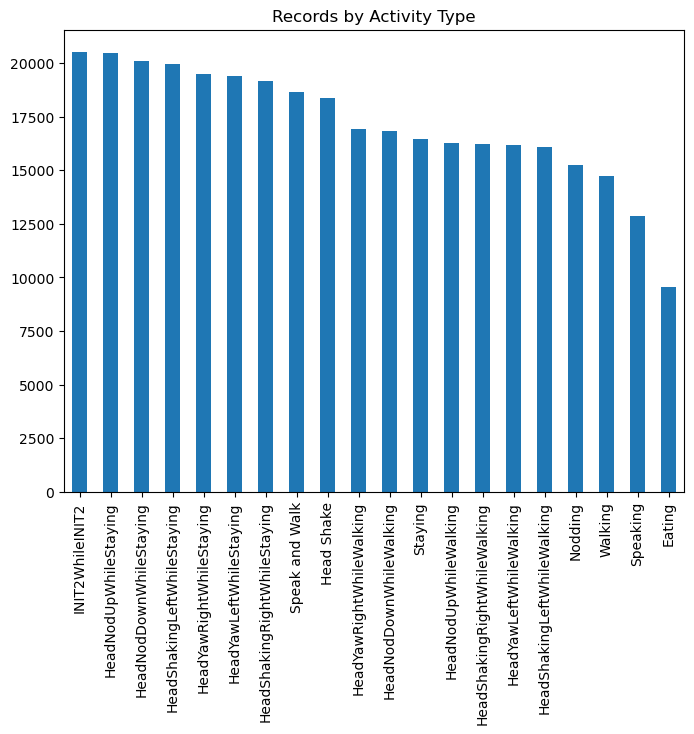

In [129]:
df['Activity'].value_counts().plot(kind='bar', title='Records by Activity Type', figsize=(8, 6),align='center');

In [130]:
X=df
y=df['Activity']
df['Ax'] = df['Ax'] / df['Ax'].max()
df['Ay'] = df['Ay'] / df['Ay'].max()
df['Az'] = df['Az'] / df['Az'].max()

df['Gx'] = df['Gx'] / df['Gx'].max()
df['Gy'] = df['Gy'] / df['Gy'].max()
df['Gz'] = df['Gz'] / df['Gz'].max()

# Round numbers
df = df.round({'Ax': 5, 'Ay': 5, 'Az': 5, 'Gx': 5, 'Gy': 5, 'Gz': 5})
N_TIME_STEPS = 70
N_FEATURES = 6
step = 5
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    Ax = df['Ax'].values[i: i + N_TIME_STEPS]
    Ay = df['Ay'].values[i: i + N_TIME_STEPS]
    Az = df['Az'].values[i: i + N_TIME_STEPS]
    
    Gx = df['Gx'].values[i: i + N_TIME_STEPS]
    Gy = df['Gy'].values[i: i + N_TIME_STEPS]
    Gz = df['Gz'].values[i: i + N_TIME_STEPS]
    
    label = stats.mode(df['Activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([Ax, Ay, Az, Gx, Gy, Gz])
    labels.append(label)

/tmp/ipykernel_32/2979583462.py:27: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['Activity'][i: i + N_TIME_STEPS])[0][0]
/tmp/ipykernel_32/2979583462.py:27: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  label = stats.mode(df['Activity'][i: i + N_TIME_STEPS])[0][0]


In [131]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
print('reshaped_segments : ', reshaped_segments.shape)
print('labels : ', labels.shape)

reshaped_segments :  (68684, 70, 6)
labels :  (68684, 20)


In [132]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.3)
X_trrain, X_teest, y_trrain, y_teest = train_test_split(X_train, y_train, test_size=0.2)

In [133]:
X_trrain.shape

(38462, 70, 6)

In [134]:
X_teest.shape

(9616, 70, 6)

In [135]:
X_test.shape

(20606, 70, 6)

In [136]:
X_test1=X_test[0:6869]
y_test1=y_test[0:6869]
X_test2=X_test[6869:13738]
y_test2=y_test[6869:13738]
X_test3=X_test[13738:20606]
y_test3=y_test[13738:20606]

In [137]:
X_test3.shape

(6868, 70, 6)

In [138]:
X_trrain.shape

(38462, 70, 6)

In [139]:
X_teest.shape

(9616, 70, 6)

In [140]:
verbose = 1
epochs = 25
batch_size = 100
fig_size=(14,7)

n_timesteps = X_trrain.shape[1]
n_features = X_trrain.shape[2]
n_outputs = y_trrain.shape[1]

print('n_timesteps : ', n_timesteps)
print('n_features : ', n_features)
print('n_outputs : ', n_outputs)

n_timesteps :  70
n_features :  6
n_outputs :  20


In [141]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, LSTM, Dense, Flatten
import tensorflow_addons as tfa


In [142]:

def CREATE_MODEL(input_shape):

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    return model

def COMPILE(model):
    model.compile(
    optimizer='adam',  
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )
    return model;
    
def FIT(model,X,y,X_teest, y_teest,i):
    
    history = model.fit(
    X_trrain,
    y_trrain,
    validation_data=(X_teest, y_teest), 
    epochs=epochs,
    batch_size=batch_size, 
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(f'/kaggle/working/model_{i}.h5', save_best_only=True),

        
#        tf.keras.callbacks.ModelCheckpoint('/kaggle/working/model_{i}.h5', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=1
        )
    ],
    verbose=1
    )
    return history,model

def PLOT(history,i):
    epochs_range = range(epochs)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=fig_size)
    plt.plot(epochs_range,train_loss,label="Training Loss")
    plt.plot(epochs_range,val_loss,label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Model {i} - Loss Over Time")
    plt.show()
    
    plt.figure(figsize=fig_size)
    plt.plot(epochs_range,train_acc,label="Training accuracy")
    plt.plot(epochs_range,val_acc,label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title(f"Model {i} - Accuracy")
    plt.show()

def CONFUSION_MATRIX(y_test, y_pred):
    confusionMatrix = confusion_matrix(y_test, y_pred)
    sns.set(font_scale=1.5)
    labels = ['INIT2WhileINIT2','HeadNodUpWhileStaying','HeadNodDownWhileStaying','HeadShakingLeftwhileStaying','HeadYawRightWhileStaying','HeadYawLeftwhileStaying','HeadShakingRightwhileStaying','Speak and Walk','Head Shake','HeadYawRightWhileWalking','HeadNodDownWhileWalking','Staying','HeadNodUpWhileWalking','HeadShakingRightWhileWalking','HeadYawLeftWhileWalking','HeadShakingLeftWhileWalking','Nodding','Walking','Speaking','Eating']
    plt.figure(figsize=(16,7))
    sns.heatmap(confusionMatrix, cmap = "Blues", annot = True, fmt = ".0f", xticklabels=labels, yticklabels=labels)
    plt.title("Global Model Confusion Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 45)
    plt.show()
    
def LOAD_MODELS():
    for i in range(1,4):
        model = load_model(f'/kaggle/working/model_{i}.h5')
        all_models.append(model)

def APPLY_WEIGHT_FUNCTION(weights):
    avg_model_weights = []
    n_models = len(all_models)
    n_layers = len(all_models[0].get_weights())
    for layer in range(n_layers):
        layer_weights = np.array([model.get_weights()[layer] for model in all_models])
        avg_layer_weights = np.average(layer_weights, axis=0, weights=weights)
        avg_model_weights.append(avg_layer_weights)
    return avg_model_weights;





In [143]:
# MODEL REPLICA NO.1
X_train_1 = X_trrain[0:12822]
y_train_1 = y_trrain[0:12822]
#X_train_1, y_train_1 = PREPROCESS(X_train_1,y_train_1);
model_1 = CREATE_MODEL(X_train_1.shape[1]);
model_1.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_26 (Conv1D)          (None, 68, 64)            1216      
                                                                 
 conv1d_27 (Conv1D)          (None, 68, 64)            12352     
                                                                 
 dropout_13 (Dropout)        (None, 68, 64)            0         
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 34, 64)           0         
 g1D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 2176)              0         
                                                                 
 dense_26 (Dense)            (None, 100)               217700    
                                                     

In [144]:
X_test_1 = X_teest[0:3205]
y_test_1 = y_teest[0:3205]
model_1 = COMPILE(model_1)
#history_1,model_1 = FIT(model_1,X_train_1,y_train_1,X_test_1,y_test_1,1)
#PLOT(history_1,1)

In [145]:
X_train_2 = X_trrain[12822:25644]
y_train_2 = y_trrain[12822:25644]
model_2 = CREATE_MODEL(X_train_2.shape[1])
model_2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 68, 64)            1216      
                                                                 
 conv1d_29 (Conv1D)          (None, 68, 64)            12352     
                                                                 
 dropout_14 (Dropout)        (None, 68, 64)            0         
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 34, 64)           0         
 g1D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 2176)              0         
                                                                 
 dense_28 (Dense)            (None, 100)               217700    
                                                     

In [146]:
X_test_2 = X_teest[3205:6410]
y_test_2 = y_teest[3205:6410]
model_2 = COMPILE(model_2)
#history_2,model_2 = FIT(model_2,X_train_2,y_train_2,X_test_2,y_test_2,2);
#PLOT(history_2,2);

In [147]:
X_train_3 = X_trrain[25644:38462]
y_train_3 = y_trrain[25644:38462]
model_3 = CREATE_MODEL(X_train_3.shape[1])
model_3.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 68, 64)            1216      
                                                                 
 conv1d_31 (Conv1D)          (None, 68, 64)            12352     
                                                                 
 dropout_15 (Dropout)        (None, 68, 64)            0         
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 34, 64)           0         
 g1D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 2176)              0         
                                                                 
 dense_30 (Dense)            (None, 100)               217700    
                                                     

In [148]:
X_test_3 = X_teest[6410:9616]
y_test_3 = y_teest[6410:9616]
model_3 = COMPILE(model_3);
#history_3, model_3 = FIT(model_3,X_train_3,y_train_3,X_test_3,y_test_3,3)
#PLOT(history_3,3)

In [149]:
model_g = CREATE_MODEL(X_test.shape[1])
model_g.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 68, 64)            1216      
                                                                 
 conv1d_33 (Conv1D)          (None, 68, 64)            12352     
                                                                 
 dropout_16 (Dropout)        (None, 68, 64)            0         
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 34, 64)           0         
 g1D)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 2176)              0         
                                                                 
 dense_32 (Dense)            (None, 100)               217700    
                                                     

In [150]:
# Define number of FL iterations
n_iterations = 5

# Start FL loop
for iteration in range(n_iterations):

    print(f"FL Iteration: {iteration+1}")

    # Training local models (model_1, model_2, model_3)
    history_1, model_1 = FIT(model_1, X_train_1, y_train_1, X_test_1, y_test_1, 1)
    history_2, model_2 = FIT(model_2, X_train_2, y_train_2, X_test_2, y_test_2, 2)
    history_3, model_3 = FIT(model_3, X_train_3, y_train_3, X_test_3, y_test_3, 3)
    
    all_models = []
    LOAD_MODELS()

    # Aggregate weights of local models
    weights = [max(history_1.history['accuracy']), max(history_2.history['accuracy']), max(history_3.history['accuracy'])]
    x = max(weights)
    idx = weights.index(x)
    weights[idx] = 1
    x = min(weights)
    idx = weights.index(x)
    weights[idx] = 0.02
    for i in range(3):
        if(weights[i] != 1 and weights[i] != 0.02):
            weights[i] = 0.03
            break
    avg_model_weights = APPLY_WEIGHT_FUNCTION(weights)

    # Update global model weights
    model_g.set_weights(avg_model_weights)
    model_g = COMPILE(model_g)

    # Evaluate global model
    _ , accuracy = model_g.evaluate(X_test, y_test, verbose=1)
    print("Global Model Accuracy: {:.2f}%".format(accuracy*100))
    

    # Evaluate local models after weight updates
    _, accuracy_1 = model_1.evaluate(X_test1, y_test1, verbose=1)
    print(f"Local Model 1 Accuracy after update: {accuracy_1*100:.2f}%")
    _, accuracy_2 = model_2.evaluate(X_test2, y_test2, verbose=1)
    print(f"Local Model 2 Accuracy after update: {accuracy_2*100:.2f}%")
    _, accuracy_3 = model_3.evaluate(X_test3, y_test3, verbose=1)
    print(f"Local Model 3 Accuracy after update: {accuracy_3*100:.2f}%")


    # Distribute global model weights back to local models
    model_1.set_weights(model_g.get_weights())
    model_2.set_weights(model_g.get_weights())
    model_3.set_weights(model_g.get_weights())
    


FL Iteration: 1
Epoch 1/25
385/385 [==============================] - 10s 23ms/step - loss: 1.3390 - accuracy: 0.5513 - val_loss: 0.8834 - val_accuracy: 0.7360 - lr: 0.0010
Epoch 2/25
385/385 [==============================] - 9s 22ms/step - loss: 0.7134 - accuracy: 0.7646 - val_loss: 0.6309 - val_accuracy: 0.8203 - lr: 0.0010
Epoch 3/25
385/385 [==============================] - 9s 22ms/step - loss: 0.5530 - accuracy: 0.8210 - val_loss: 0.5529 - val_accuracy: 0.8443 - lr: 0.0010
Epoch 4/25
385/385 [==============================] - 9s 22ms/step - loss: 0.4720 - accuracy: 0.8477 - val_loss: 0.4929 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 5/25
385/385 [==============================] - 9s 23ms/step - loss: 0.4149 - accuracy: 0.8666 - val_loss: 0.4240 - val_accuracy: 0.8846 - lr: 0.0010
Epoch 6/25
385/385 [==============================] - 9s 22ms/step - loss: 0.3744 - accuracy: 0.8802 - val_loss: 0.3819 - val_accuracy: 0.8961 - lr: 0.0010
Epoch 7/25
385/385 [===========================